In [7]:
import pandas as pd
import numpy as np
import matplotlib

#### Import the ipo info file, which has ipo first trade date:

In [8]:
ipo_info_file_path = 'data/raw/IPO_Info.csv'
ipo_info_df = pd.read_csv(ipo_info_file_path)

In [9]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,AGRO,1/28/2011,11.0,AGRICULTRE,Agricultural Operations,NaN,NaN,NaN,NaN
1,BKU,1/28/2011,27.0,S&Ls,Finance-Savings & Loan,NaN,NaN,NaN,NaN
2,INXN,1/28/2011,13.0,INTERNET,Internet-Network Sltns,NaN,NaN,NaN,NaN
3,NPTN,2/2/2011,11.0,ELECTRNCS,Electronic-Parts,NaN,NaN,NaN,NaN
4,FLDM,2/10/2011,13.5,MEDICAL,Medical-Systems/Equip,NaN,NaN,NaN,NaN


#### Remove extra columns 

In [10]:
ipo_info_df.drop(ipo_info_df.iloc[:, 5:9], axis=1, inplace=True)

In [11]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry
0,AGRO,1/28/2011,11.0,AGRICULTRE,Agricultural Operations
1,BKU,1/28/2011,27.0,S&Ls,Finance-Savings & Loan
2,INXN,1/28/2011,13.0,INTERNET,Internet-Network Sltns
3,NPTN,2/2/2011,11.0,ELECTRNCS,Electronic-Parts
4,FLDM,2/10/2011,13.5,MEDICAL,Medical-Systems/Equip


#### Convert date column to proper date type:

In [12]:
ipo_info_df['IPO Date'] = pd.to_datetime(ipo_info_df['IPO Date'])

In [13]:
ipo_info_df.head()

,Symbol,IPO Date,Offer Price,Sector,Industry
0,AGRO,2011-01-28,11.0,AGRICULTRE,Agricultural Operations
1,BKU,2011-01-28,27.0,S&Ls,Finance-Savings & Loan
2,INXN,2011-01-28,13.0,INTERNET,Internet-Network Sltns
3,NPTN,2011-02-02,11.0,ELECTRNCS,Electronic-Parts
4,FLDM,2011-02-10,13.5,MEDICAL,Medical-Systems/Equip


#### Import the IPO end of day data file:

In [14]:
ipo_eod_data_file_path = 'data/raw/EOD_Data.csv'
ipo_eod_data_df = pd.read_csv(ipo_eod_data_file_path)

In [15]:
ipo_eod_data_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,VWAP
0,AAAP,11/11/2015,18.50,25.90,18.00,24.50,1584639.0,20.1547
1,AAAP,1/28/2016,23.71,25.08,23.01,23.81,310937.0,23.6635
2,AAAP,1/26/2016,25.00,25.11,20.53,24.86,53747.0,23.6999
3,AAAP,1/29/2016,23.19,24.97,23.18,24.88,60790.0,23.9222
4,AAAP,2/9/2016,24.00,25.23,23.89,24.06,23039.0,24.4341


In [16]:
%%time
ipo_eod_data_df['Date'] = pd.to_datetime(ipo_eod_data_df['Date'])

Wall time: 1min 36s


In [17]:
ipo_eod_data_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,VWAP
0,AAAP,2015-11-11,18.50,25.90,18.00,24.50,1584639.0,20.1547
1,AAAP,2016-01-28,23.71,25.08,23.01,23.81,310937.0,23.6635
2,AAAP,2016-01-26,25.00,25.11,20.53,24.86,53747.0,23.6999
3,AAAP,2016-01-29,23.19,24.97,23.18,24.88,60790.0,23.9222
4,AAAP,2016-02-09,24.00,25.23,23.89,24.06,23039.0,24.4341


In [18]:
ipo_info_df['Symbol'].count()

917

In [19]:
# a structure to store execution data
execution = {
    'quantity':0,
    'symbol':'',
    'price':0.0,
    'date':''
}

# a strcuture to store daily returns for equity curve
daily_returns = {
    'date':'',
    'pnl':0.0
}

In [20]:
def backtest_symbol(symbol, start_date):
    
    
    # get the price data starting from IPO Date sorted by date
    price_data = ipo_eod_data_df[(ipo_eod_data_df.Symbol==symbol) & (ipo_eod_data_df.Date >= start_date)].sort_values(by=['Date'])
    
    days_since_ipo = 0
    all_time_high = 0.0
    low0 = 99990.0
    low1 = 99990.0
    low2 = 99990.0
    low3 = 99990.0
    
    entry_triggered = False
    
    execution_list = []
    daily_returns_list = []
    position = 0
    previous_close = 0
    entry_date = ''
    
    # iterate through the days starting with ipo date
    for index, row in price_data.iterrows():
        if entry_triggered:
            execution_list.append({'Quantity':100,'Symbol':symbol,'Price':row['VWAP'],'Date':row['Date']})
            position = 100
            entry_date = row['Date']
            entry_triggered = False
        
        days_since_ipo += 1
        
        new_high = False
        if row['High'] > all_time_high: 
            all_time_high = row['High']
            new_high = True
            
        # update 3 day low
        low3 = low2
        low2 = low1
        low1 = low0
        low0 = row['Low']
        
        three_day_low = min(low1,low2,low3)
        
        # check if entry triggered
        if (position == 0
            and days_since_ipo > 5 
            and new_high):
            entry_triggered = True 
            #note: will enter next day vwap
            
        # check if stopped out
        if position != 0:
            if (row['Low'] < three_day_low
                and entry_triggered == False):
                execution_list.append({'Quantity':(position*-1),'Symbol':symbol,'Price':three_day_low,'Date':row['Date']})
                daily_returns_list.append({'Date':row['Date'],'pnl':((three_day_low - previous_close) * position)})
                position = 0
            else:
                # record daily returns
                change = 0.0
                if entry_date == row['Date']:
                    # today was the entry
                    change = row['Close'] - row['VWAP']
                else:
                    change = row['Close'] - previous_close
                
                daily_returns_list.append({'Date':row['Date'],'pnl':(change * position)})
            
        previous_close = row['Close']
        
              
    executions_df = pd.DataFrame(execution_list)
    daily_returns_df = pd.DataFrame(daily_returns_list)
        
    return (executions_df,daily_returns_df)
        

#### Test 1 Symbol

In [30]:
result_tuple = backtest_symbol('ROKU','2017-09-28')

Trades in ROKU:

In [31]:
result_tuple[0]

,Date,Price,Quantity,Symbol
0,2017-11-13,41.2980,100,ROKU
1,2017-11-21,37.7500,-100,ROKU
2,2017-11-29,45.2236,100,ROKU
3,2017-12-04,42.3100,-100,ROKU
4,2017-12-18,55.5069,100,ROKU
5,2017-12-21,52.4300,-100,ROKU


Roku daily returns:

In [32]:
result_tuple[1]

,Date,pnl
0,2017-11-13,141.20
1,2017-11-14,-576.00
2,2017-11-15,237.00
3,2017-11-16,47.00
4,2017-11-17,-120.00
5,2017-11-20,43.00
6,2017-11-21,-127.00
7,2017-11-29,-35.36
8,2017-11-30,-97.00
9,2017-12-01,-35.00


Roku Price Data Used:

In [34]:
price_data = ipo_eod_data_df[(ipo_eod_data_df.Symbol=='ROKU') & (ipo_eod_data_df.Date >= '2017-11-08')].sort_values(by=['Date'])
    

In [35]:
price_data

,Symbol,Date,Open,High,Low,Close,Volume,VWAP
185201,ROKU,2017-11-08,19.30,19.43,18.56,18.84,4730598.0,21.2094
185217,ROKU,2017-11-09,24.75,29.44,23.86,29.19,33372110.0,27.4047
185249,ROKU,2017-11-10,30.91,36.65,30.50,33.25,34527445.0,34.1436
185288,ROKU,2017-11-13,34.88,47.49,34.86,42.71,53078336.0,41.2980
185293,ROKU,2017-11-14,46.74,48.80,36.58,36.95,56821123.0,42.4183
185261,ROKU,2017-11-15,34.61,39.75,34.22,39.32,22401099.0,37.9236
185275,ROKU,2017-11-16,42.00,42.75,38.11,39.79,18503382.0,40.5079
185267,ROKU,2017-11-17,38.92,40.57,37.75,38.59,7572593.0,39.1652
185269,ROKU,2017-11-20,39.10,39.95,38.60,39.02,5895333.0,39.2670
185262,ROKU,2017-11-21,39.00,39.42,37.19,37.26,5433461.0,38.2952


#### Test All Stocks and time execution:

In [36]:
%%time
# iterate through the symbol list
all_executions = None
all_returns = None
for index, row in ipo_info_df.iterrows():
    
    symbol = row['Symbol']
    start_date = row['IPO Date']
    
    results = backtest_symbol(symbol, start_date)
    
    if all_executions is None:
        all_executions = results[0]
        all_returns = results[1]
    else:
        all_executions = pd.concat([all_executions, results[0]])
        all_returns = pd.concat([all_returns, results[1]])

Wall time: 1min 31s


In [38]:
sorted_returns = all_returns.sort_values(['Date'])
returns = sorted_returns.groupby(['Date'])['pnl'].sum()

In [40]:
cumulative_sums = returns.cumsum()

In [41]:
%matplotlib inline

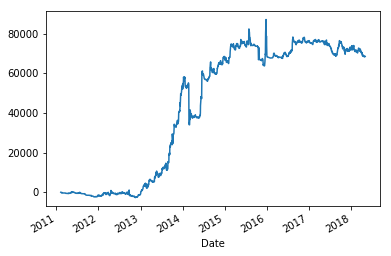

In [42]:
cumulative_sums.plot.line()

In [46]:
cumulative_sums.tail()

Date
2018-05-01    68489.35
2018-05-02    68591.60
2018-05-03    68505.53
2018-05-04    68380.48
2018-05-07    68563.77
Name: pnl, dtype: float64

In [47]:
all_executions['abs_shares'] = abs(all_executions['Quantity'])

In [58]:
shares_traded = all_executions.abs_shares.sum()
shares_traded

621400

In [59]:
gross = all_returns.sum()
gross

pnl    68563.77
dtype: float64

In [61]:
commission = shares_traded * .007
commission

4349.8

In [62]:
net = gross - commission
net

pnl    64213.97
dtype: float64

In [64]:
cps = gross / shares_traded
cps

pnl    0.110338
dtype: float64